# Smokescreen Prototype

This is an exploratory prototying notebook for the Smokescreen project.
Loading firecrown likelighoods, smokescreen will try to find to conceal the data-vectors to avoid confirmation bias in the cosmological parameters.

In [1]:
%matplotlib inline
import pylab as plt
from firecrown.likelihood.likelihood import load_likelihood
from firecrown.likelihood.likelihood import load_likelihood_from_module_type
from firecrown.parameters import ParamsMap
import numpy as np
import sacc
import pathlib
import pyccl as ccl
from firecrown.modeling_tools import ModelingTools
import firecrown
import sys
import os
from copy import deepcopy
# we need to import a firecrown example likelihood:
# exports the path to the environment variable FIRECROWN_DIR
os.environ["FIRECROWN_DIR"] = os.path.dirname('/Users/loureiro/Work/Github/firecrown/')


In [2]:
# importing the example likelihood module from the firecrown examples
sys.path.append(os.path.join(os.environ["FIRECROWN_DIR"], "examples", "des_y1_3x2pt"))
# trying to import the example likelihood
import des_y1_3x2pt_PT 

In [3]:
print(hasattr(des_y1_3x2pt_PT, "build_likelihood"))

True


## Generating a theory-vector

In [4]:
# ccl cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      sigma8=0.8, 
                      n_s=0.96, 
                      transfer_function='bbks')
cosmo_bl = ccl.Cosmology(Omega_c=0.27, 
                        Omega_b=0.045, 
                        h=0.72, 
                        sigma8=0.76, 
                        n_s=0.96, 
                        transfer_function='bbks')
cosmo.compute_nonlin_power()
cosmo_bl.compute_nonlin_power()

In [5]:
# preparting the likelihood
likelihood, tools = load_likelihood_from_module_type(des_y1_3x2pt_PT, None)

Using parameters: ['lens0_b_s', 'ia_a_d', 'lens0_mag_bias', 'ia_a_2', 'src0_delta_z', 'ia_a_1', 'lens0_delta_z', 'lens0_b_2', 'lens0_bias']


/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/sacc/sacc.py:974: UserWarning: No bandpower windows associated to these data
  warnings.warn("No bandpower windows associated to these data")


In [6]:
import types

if isinstance(des_y1_3x2pt_PT, types.ModuleType):
    print("des_y1_3x2pt_PT is a module")
else:
    print("des_y1_3x2pt_PT is not a module")


des_y1_3x2pt_PT is a module


In [7]:
hasattr(likelihood, "compute_theory_vector")

True

This comes from the example file, but we would expect the user to provide a dictionary of fiductial parameters for the systeamatics

In [8]:
cs = des_y1_3x2pt_PT.CclSetup()
systematics_params = ParamsMap(
        {
            "ia_a_1": cs.a_1,
            "ia_a_2": cs.a_2,
            "ia_a_d": cs.a_d,
            "lens0_bias": cs.b_1,
            "lens0_b_2": cs.b_2,
            "lens0_b_s": cs.b_s,
            "lens0_mag_bias": cs.mag_bias,
            "src0_delta_z": 0.000,
            "lens0_delta_z": 0.000,
        }
    )

In [9]:
tools_blinding = deepcopy(tools)

# FIXME: is this correct or can we skip this step?
tools.update({})
tools_blinding.update({})

# prepare the tools with the cosmology
tools.prepare(cosmo)
tools_blinding.prepare(cosmo_bl)

likelihood.update(ParamsMap(systematics_params))

In [10]:
tools_blinding.get_ccl_cosmology()

<pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.045
	Omega_c = 0.27
	h       = 0.72
	n_s     = 0.96
	sigma8  = 0.76
	transfer_function = bbks
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x7707664dc6bae115

In [11]:
theory_vec_fid = likelihood.compute_theory_vector(tools)
theory_vec_shifted = likelihood.compute_theory_vector(tools_blinding)
data_vect_original = likelihood.get_data_vector()

/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/pyccl/nl_pt/ept.py:375: CCLWarning: EulerianPTCalculators assume linear galaxy bias when computing galaxy-IA cross-correlations.
  warnings.warn(


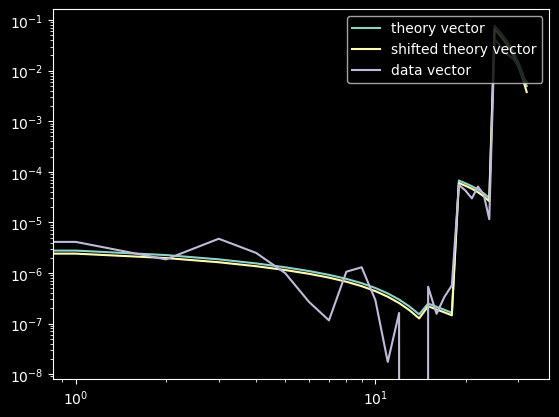

In [12]:
plt.figure()
plt.loglog(theory_vec_fid, label='theory vector')
plt.loglog(theory_vec_shifted, label='shifted theory vector')
plt.loglog(data_vect_original, label='data vector')
plt.legend(loc=1)
plt.show()

In [13]:
list(likelihood.required_parameters().get_params_names())


['lens0_b_s',
 'ia_a_d',
 'lens0_mag_bias',
 'ia_a_2',
 'src0_delta_z',
 'ia_a_1',
 'lens0_delta_z',
 'lens0_b_2',
 'lens0_bias']

In [14]:
cosmo._params

{'A_s': nan, 'H0': 67.0, 'N_nu_mass': 0, 'N_nu_rel': 3.044, 'Neff': 3.044, 'Omega_b': 0.045, 'Omega_c': 0.27, 'Omega_g': 5.508778298729024e-05, 'Omega_k': 0.0, 'Omega_l': 0.6849068292242229, 'Omega_m': 0.315, 'Omega_nu_mass': 0.0, 'Omega_nu_rel': 3.808299279000258e-05, 'T_CMB': 2.7255, 'T_ncdm': 0.71611, 'bcm_etab': 0.0, 'bcm_ks': 0.0, 'bcm_log10Mc': 0.0, 'c1_mg': 1.0, 'c2_mg': 1.0, 'df_mgrowth': None, 'h': 0.67, 'has_mgrowth': False, 'k_sign': 0, 'lambda_mg': 0.0, 'm_nu': [], 'mu_0': 0.0, 'n_s': 0.96, 'nz_mgrowth': 0, 'sigma8': 0.8, 'sigma_0': 0.0, 'sqrtk': 0.0, 'sum_nu_masses': 0.0, 'w0': -1.0, 'wa': 0.0, 'z_mgrowth': None, 'z_star': 0.0}

## Cosmological Shifts

In [54]:
shifts_dict_test = {'H0': (-5, +5), 
                    'Naotem': (0.5, 1.5),
                     'Omega_b': 0.001}

In [55]:
# check if the shifts keys are in the cosmology parameters:

def load_shifts(shifts_dict):
    """
    if shifts is true, assumes the tuples values are (upper, lower) and the 
    """
    failed_keys = []
    for key in shifts_dict.keys():
        try:
            cosmo._params[key]
        except AttributeError:
            # remove the key from the shifts_dict
            print(f"Key {key} not in cosmology parameters")
            failed_keys.append(key)
    for key in failed_keys:
        shifts_dict.pop(key)
    shifts = {}
    for key, value in shifts_dict.items():
        if isinstance(value, tuple):
            # check if the tuple is of length 2
            if len(value) == 2:
                if value[0] < 0:
                    shifts[key] = cosmo[key] + np.random.uniform(value[0], value[1])
                else:
                    shifts[key] = np.random.uniform(value[0], value[1])
            else:
                raise ValueError(f"Tuple {value} has to be of length 2")
        else:
            shifts[key] = cosmo[key] + value
    return shifts

In [56]:
load_shifts(shifts_dict_test)

Key Naotem not in cosmology parameters


{'H0': 71.51039869168316}